# Notebook for testing diffusion models regarding parameters such as grain/domain size and cooling rate for different thermochronology systems

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.constants import Julian_year
from scipy.optimize import minimize
%config InlineBackend.figure_format='retina'

## compilation of diffusion paramter from experimental results  

In [8]:
diffusion_compilation = pd.read_csv('../data/element_diffusion_compilation.csv')
Zircon_U = diffusion_compilation[(diffusion_compilation['Host'] == 'Zircon') & (diffusion_compilation['Element']=='U')]
Zircon_Pb = diffusion_compilation[(diffusion_compilation['Host'] == 'Zircon') & (diffusion_compilation['Element']=='Pb')]
Apatite_U = diffusion_compilation[(diffusion_compilation['Host'] == 'Apatite') & (diffusion_compilation['Element']=='U')]
Apatite_Pb = diffusion_compilation[(diffusion_compilation['Host'] == 'Apatite') & (diffusion_compilation['Element']=='Pb')]

Titanite_Pb = diffusion_compilation[(diffusion_compilation['Host'] == 'Titanite') & (diffusion_compilation['Element']=='Pb')]
Monazite_Pb = diffusion_compilation[(diffusion_compilation['Host'] == 'Monazite') & (diffusion_compilation['Element']=='Pb')]
Rutile_Pb = diffusion_compilation[(diffusion_compilation['Host'] == 'Rutile') & (diffusion_compilation['Element']=='Pb')]
Hornblende_Ar = diffusion_compilation[(diffusion_compilation['Host'] == 'Hornblende') & (diffusion_compilation['Element']=='Ar')]
Biotite_Ar = diffusion_compilation[(diffusion_compilation['Host'] == 'Biotite') & (diffusion_compilation['Element']=='Ar')]
Muscovite_Ar = diffusion_compilation[(diffusion_compilation['Host'] == 'Muscovite') & (diffusion_compilation['Element']=='Ar')]
Kspar_Ar = diffusion_compilation[(diffusion_compilation['Host'] == 'K-Feldspar') & (diffusion_compilation['Element']=='Ar')]

thermochorn_df = pd.concat([Zircon_U, Zircon_Pb, Apatite_U, Apatite_Pb, Titanite_Pb, Monazite_Pb, Rutile_Pb, Hornblende_Ar, Biotite_Ar, Muscovite_Ar, Kspar_Ar]).reset_index(drop=1)
thermochorn_df['color'] = ['C'+str(index) for index in thermochorn_df.index]
thermochorn_df

,Host,Composition,Element,E,E_sigma,D0,Pressure (Mpa),Temp low,Temp high,Ref,color
0,Zircon,zircon,U,726,83.0,1.630000e+00,0.100,1450,1600,Cherniak et al. (1997b),C0
1,Zircon,zircon,Pb,545,25.0,7.760000e-02,0.100,1000,1500,Cherniak and Watson (2001),C1
2,Apatite,apatite,U,442,78.0,4.080000e-06,0.100,1150,1250,Cherniak (2005),C2
3,Apatite,apatite,Pb,231,NaN,1.270000e-08,0.100,600,1200,"Cherniak et al. (1991); Watson et al., (1985)",C3
4,Titanite,titanite,Pb,329,64.0,1.110000e-04,0.100,650,1027,Cherniak (1993),C4
5,Monazite,monazite,Pb,592,39.0,9.380000e-01,0.100,1100,1350,Cherniak (2004),C5
6,Rutile,rutile,Pb,250,12.0,3.900000e-10,0.100,700,1100,Cherniak (2000),C6
7,Hornblende,hornblende,Ar,268,7.0,2.400000e-06,0.100,500,900,Harrison (1981),C7
8,Biotite,biotite,Ar,197,9.0,7.700000e-06,0.001,600,750,"Harrison et al., (1985)",C8
9,Muscovite,muscovite,Ar,264,29.0,2.300000e-04,NaN,600,730,"Harrison et al., (2009)",C9


In [3]:
def plot_logD_vs_T(df):
    R = 8.314462618
    fig, ax = plt.subplots(figsize=(10,12))
    for i in range(df.shape[0]):
        Temp_steps = np.linspace(df['Temp low'][i]+273.15, df['Temp high'][i]+273.15, 50)
        Temp_steps_rev = 10000/Temp_steps
        logDs = np.log10(df['D0'][i] * np.exp(-df['E'][i]*1000/R/Temp_steps))
        
        ax.plot(Temp_steps_rev, logDs, label = df['Composition'][i]+ ' ' +df['Element'][i], 
                color = df['color'][i])
    return fig, ax

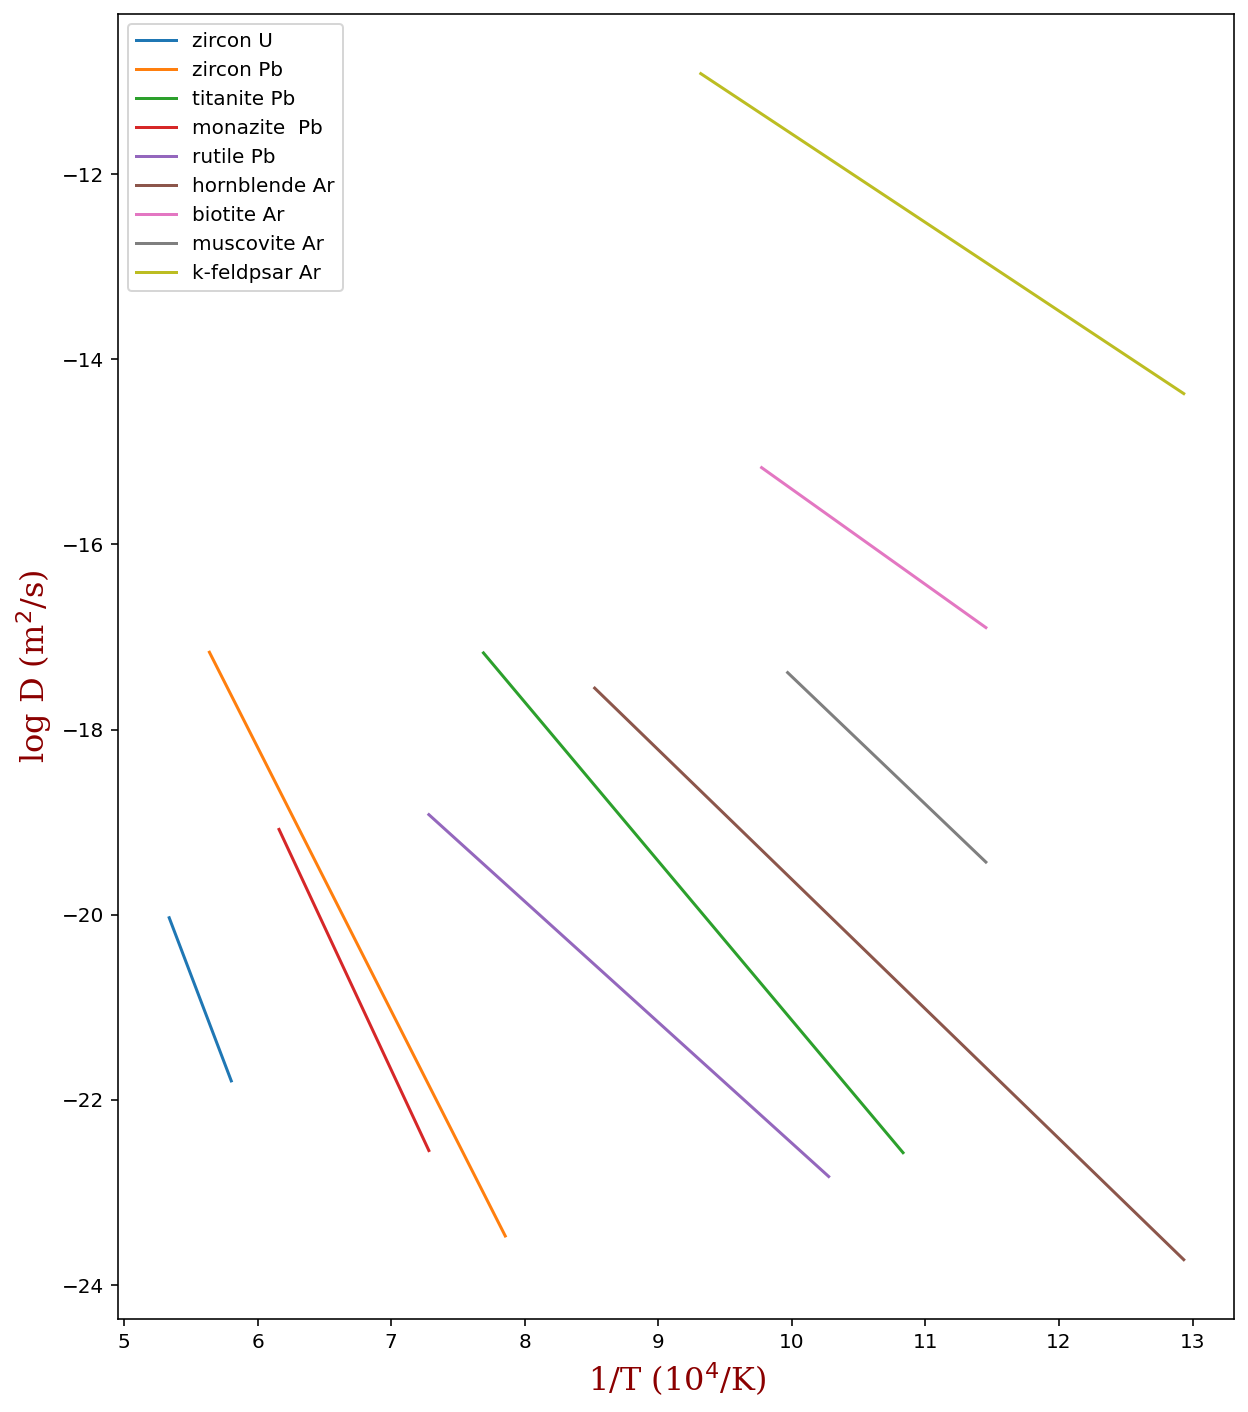

In [4]:
plot_logD_vs_T(thermochorn_df)
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

plt.xlabel('1/T (10$^4$/K)',fontdict=font)
plt.ylabel('log D (m$^2$/s)',fontdict=font)
plt.legend();

## calculation of closure temperatures based on cooling rate


**ClosureTemperaturein CoolingGeochronological and Petrological Systems, Dodson, 1973**

Closure temperature (Tc) of a geochronological system may be defined as its temperature at the time corresponding to its apparent age. For thermally activated diffusion it is given by:

$$T_c = \frac{R}{Eln(\frac{A\tau D_0}{a^2})}$$

where R is the gas constant, E is the activation energy, $\tau$ is the time constant with which the diffusion coefficient D diminishes, a is a characteristic diffusion size, and A a numerical constant depending on geometry and decay constant of parent.

The time constant z is related to cooling rate by:
$$\tau = \frac{-RT^2}{E*{cooling\ rate}}$$


**If the decay of parent is very slow, compared with the cooling time constant, A is 55, 27, or 8.7 for volume diffusion from a sphere, cylinder or plane sheet respectively.**

Dependence of Closure Temperature upon Cooling Rate:

$$\frac{E}{RT_c} = ln(-\frac{ARTc^2D_0}{a^2Er})$$

In [5]:
def closure_temps(Tc, E, D0, R, A, a, cooling_rate):
    def solution(Tc):
        return abs(E/R/Tc-np.log(A*R*Tc**2*D0/a**2/E/cooling_rate))
    Tc = Tc+273.15
    return minimize(solution, Tc, method='Nelder-Mead')['x']-273.15

In [6]:
R = 8.314462618
A = 55

In [7]:
columns=['mineral', 'a', 'b', 'c']
log_closure_temp_fit_df = pd.DataFrame(columns=columns)

### K-spar Ar closure temperature calculation and fit

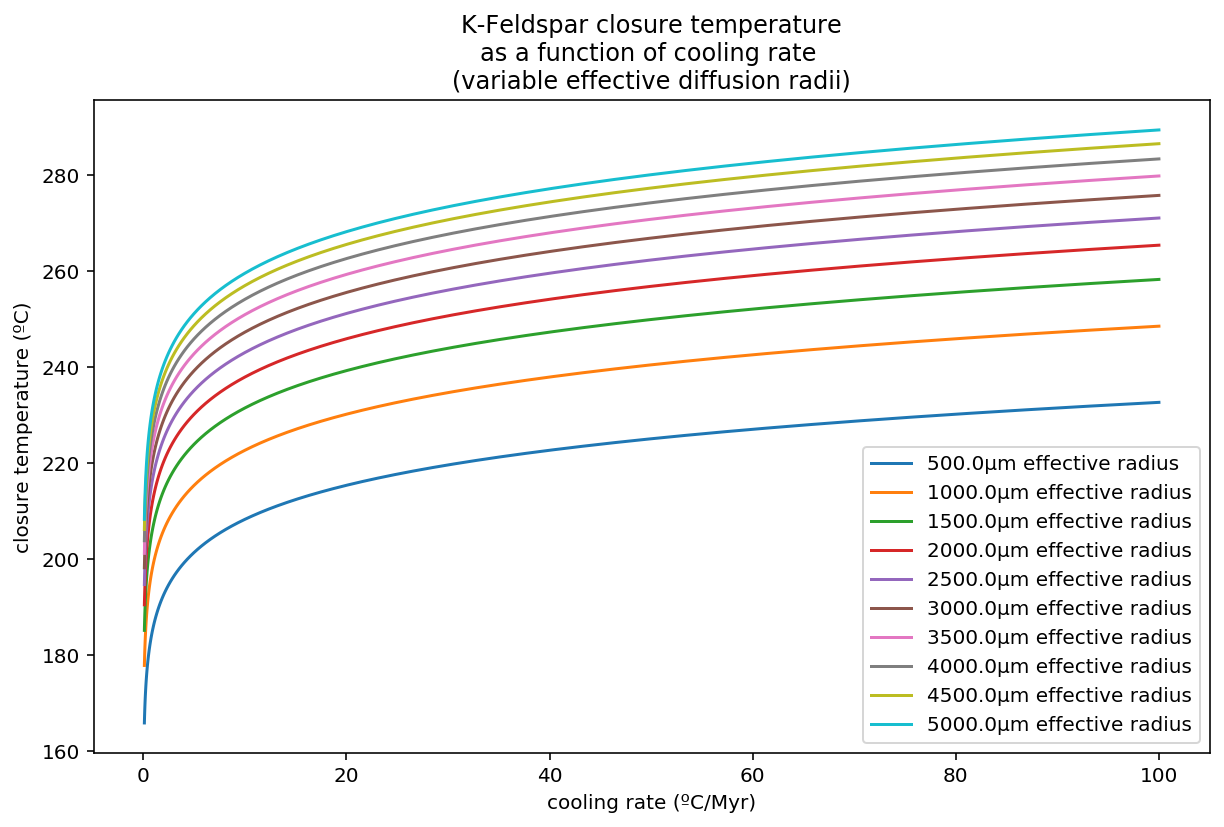

In [44]:
Kspar_E = 183*1000

Kspar_D0 = 0.00982
cooling_rate = np.logspace(-1, 2 ,100)/Julian_year/1e6

Kspar_a = 150/1e6

Kspar_a = np.linspace(500, 5000, 10)/1e6

plt.figure(figsize=(10, 6))

for a in Kspar_a:
    closure_T_list = []
    for i in cooling_rate:
        closure_T_list.append(closure_temps(350, Kspar_E, Kspar_D0, R, A, a, i))

# a, b, c = np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2)  
# a, b, c = np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1)
# x = cooling_rate*Julian_year*1e6
# y = a*np.log(x)**2+b*np.log(x)+c
# print('a: ', a, 'b: ', b, 'c: ', c)

    plt.plot(cooling_rate*Julian_year*1e6, closure_T_list, label=str(a*1e6)+'µm effective radius')
# plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('K-Feldspar closure temperature\nas a function of cooling rate \n(variable effective diffusion radii)')
plt.legend()
plt.show()

### Bioite Ar closure temperature calculation and fit

a:  0.3 b:  12.0 c:  272.1


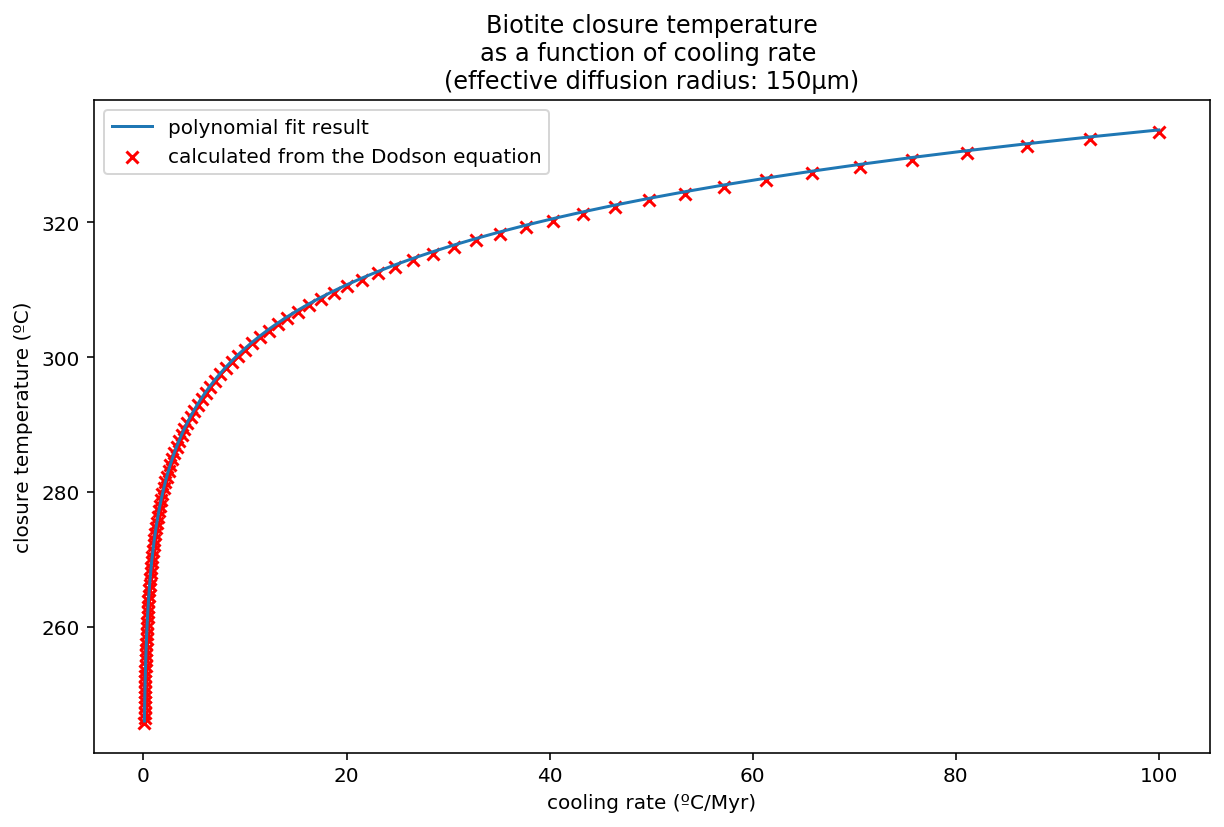

In [17]:
biotite_E = 197*1000

biotite_D0 = 0.0000077
cooling_rate = np.logspace(-1, 2 ,100)/Julian_year/1e6

biotite_a = 150/1e6

closure_T_list = []
for i in cooling_rate:
    closure_T_list.append(closure_temps(300, biotite_E, biotite_D0, R, A, biotite_a, i))

a, b, c = np.ndarray.flatten(np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1))
print('a: ', a, 'b: ', b, 'c: ', c)

fit_series = pd.Series(['Biotite', a, b, c], index = columns)
log_closure_temp_fit_df=log_closure_temp_fit_df.append(fit_series, ignore_index=1)

x = cooling_rate*Julian_year*1e6
y = a*np.log(x)**2+b*np.log(x)+c

plt.figure(figsize=(10, 6))
plt.scatter(cooling_rate*Julian_year*1e6, closure_T_list, marker ='x', color = 'r', label='calculated from the Dodson equation')
plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Biotite closure temperature\nas a function of cooling rate \n(effective diffusion radius: 150µm)')
plt.legend()
plt.show()

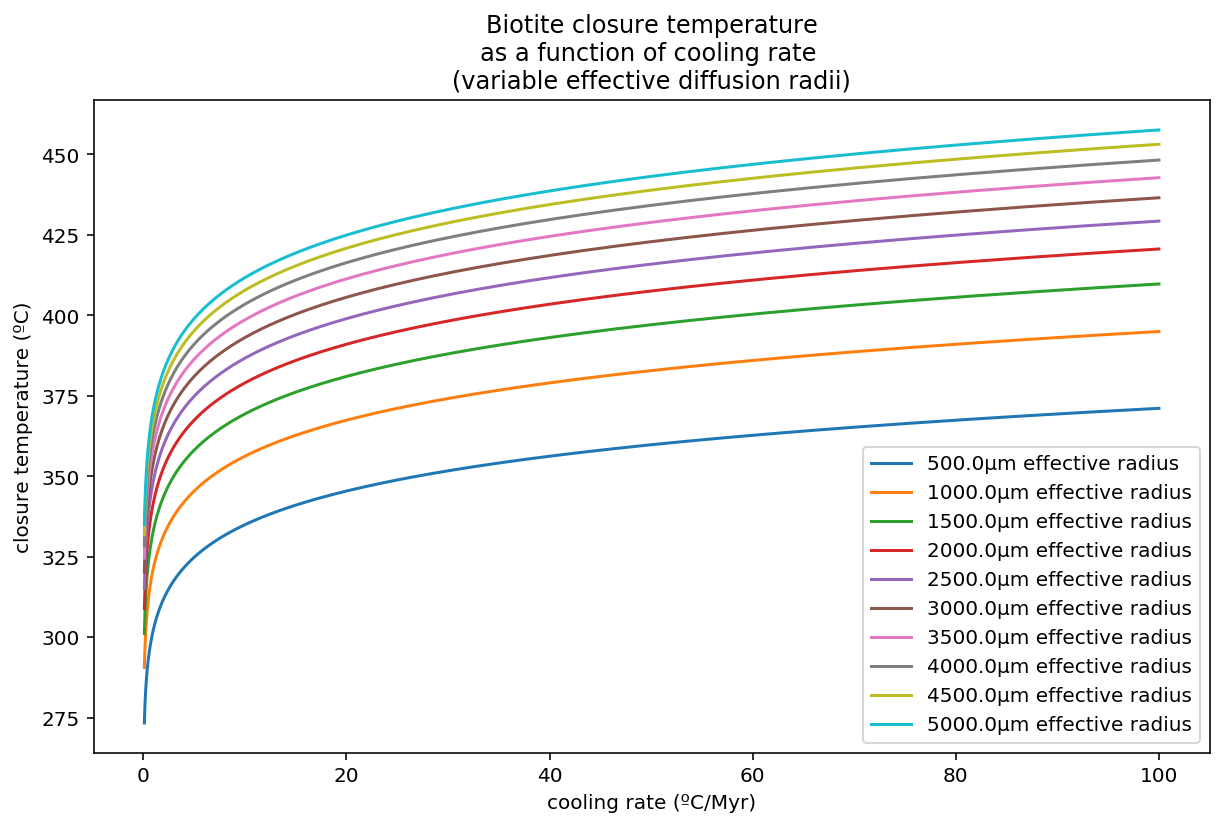

In [21]:
biotite_a = np.linspace(500, 5000, 10)/1e6

plt.figure(figsize=(10, 6))

for a in biotite_a:
    closure_T_list = []
    for i in cooling_rate:
        closure_T_list.append(closure_temps(350, biotite_E, biotite_D0, R, A, a, i))

# a, b, c = np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2)  
# a, b, c = np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1)
# x = cooling_rate*Julian_year*1e6
# y = a*np.log(x)**2+b*np.log(x)+c
# print('a: ', a, 'b: ', b, 'c: ', c)

    plt.plot(cooling_rate*Julian_year*1e6, closure_T_list, label=str(a*1e6)+'µm effective radius')
# plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Biotite closure temperature\nas a function of cooling rate \n(variable effective diffusion radii)')
plt.legend()
plt.show()

### Muscovite Ar closure temperature calculation and fit

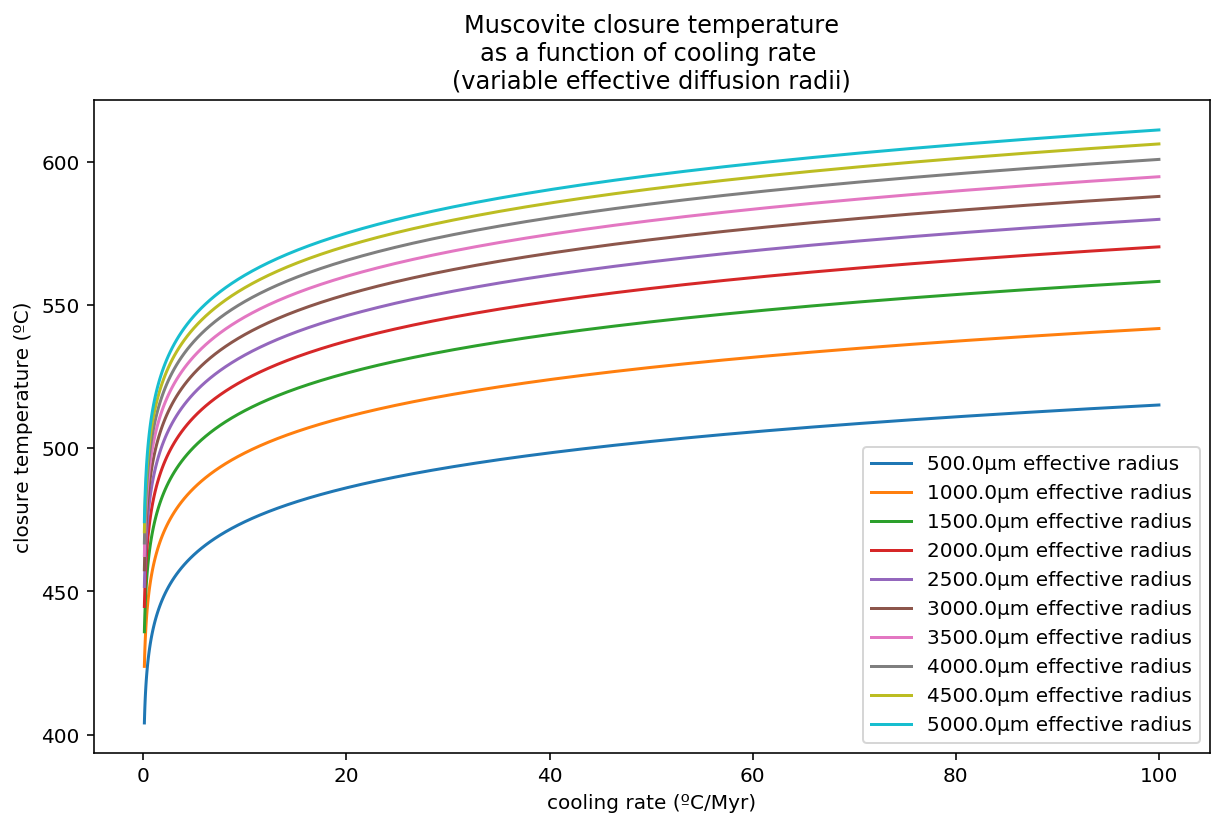

In [23]:
muscovite_a = np.linspace(50, 2000, 10)/1e6
muscovite_E = 264*1000
muscovite_D0 = 0.00023

plt.figure(figsize=(10, 6))

for a in biotite_a:
    closure_T_list = []
    for i in cooling_rate:
        closure_T_list.append(closure_temps(350, muscovite_E, muscovite_D0, R, A, a, i))

# a, b, c = np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2)  
# a, b, c = np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1)
# x = cooling_rate*Julian_year*1e6
# y = a*np.log(x)**2+b*np.log(x)+c
# print('a: ', a, 'b: ', b, 'c: ', c)

    plt.plot(cooling_rate*Julian_year*1e6, closure_T_list, label=str(a*1e6)+'µm effective radius')
# plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Muscovite closure temperature\nas a function of cooling rate \n(variable effective diffusion radii)')
plt.legend()
plt.show()

### Hornblende Ar closure temperature calculation and fit

a:  0.4 b:  17.0 c:  482.8


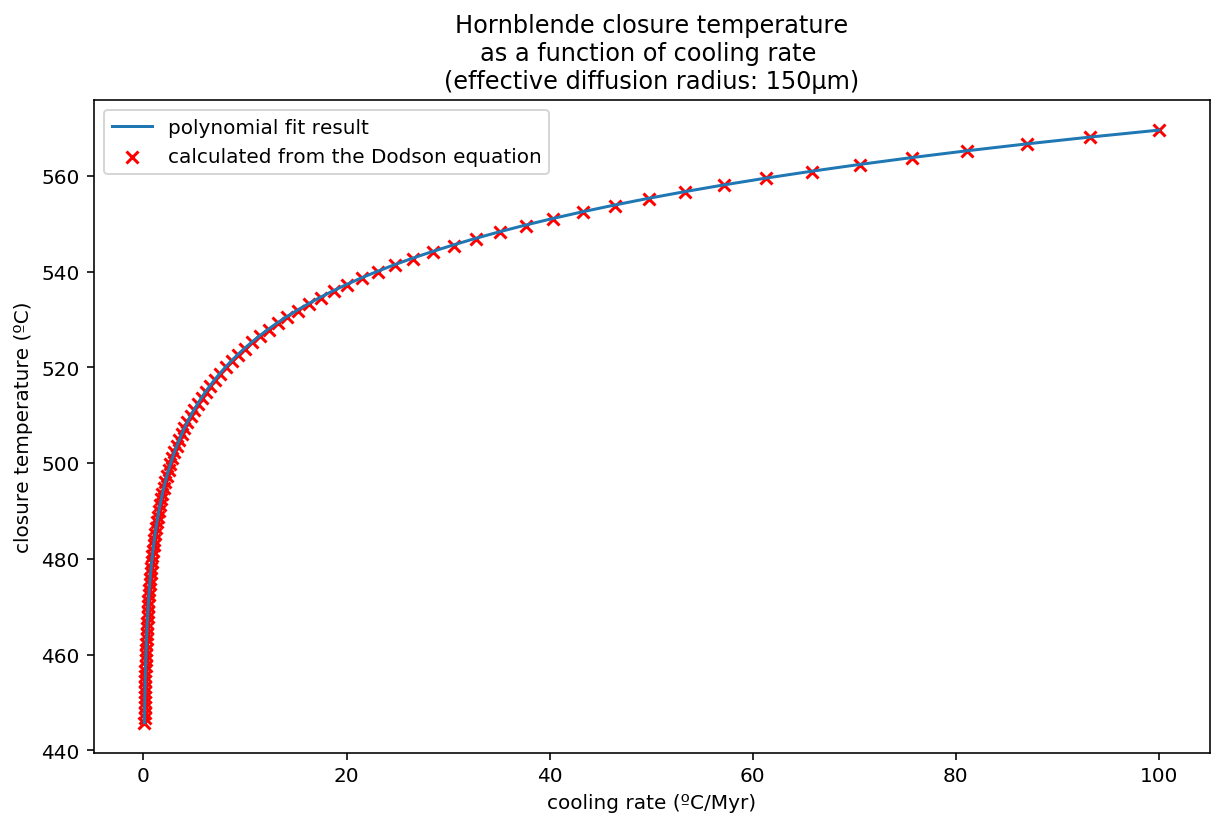

In [11]:
hornblende_E = 268*1000

hornblende_D0 = 0.0000024
cooling_rate = np.logspace(-1, 2 ,100)/Julian_year/1e6

hornblende_a = 150/1e6

closure_T_list = []
for i in cooling_rate:
    closure_T_list.append(closure_temps(300, hornblende_E, hornblende_D0, R, A, hornblende_a, i))

a, b, c = np.ndarray.flatten(np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1))
print('a: ', a, 'b: ', b, 'c: ', c)

fit_series = pd.Series(['Hornblende', a, b, c], index = columns)
log_closure_temp_fit_df=log_closure_temp_fit_df.append(fit_series, ignore_index=1)

x = cooling_rate*Julian_year*1e6
y = a*np.log(x)**2+b*np.log(x)+c

plt.figure(figsize=(10, 6))
plt.scatter(cooling_rate*Julian_year*1e6, closure_T_list, marker ='x', color = 'r', label='calculated from the Dodson equation')
plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Hornblende closure temperature\nas a function of cooling rate \n(effective diffusion radius: 150µm)')
plt.legend()
plt.show()

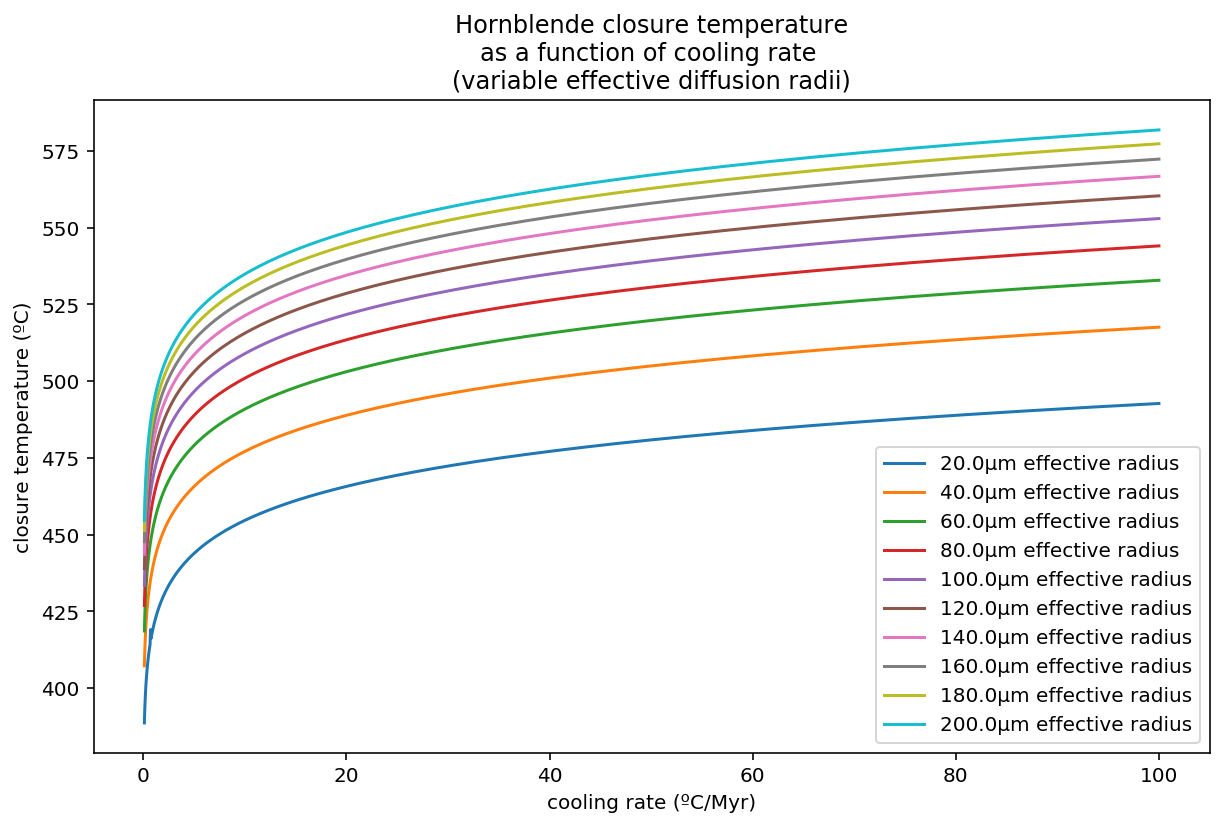

In [20]:
hornblende_a = np.linspace(20, 200, 10)/1e6

plt.figure(figsize=(10, 6))

for a in hornblende_a:
    closure_T_list = []
    for i in cooling_rate:
        closure_T_list.append(closure_temps(480, hornblende_E, hornblende_D0, R, A, a, i))

# a, b, c = np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2)  
# a, b, c = np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1)
# x = cooling_rate*Julian_year*1e6
# y = a*np.log(x)**2+b*np.log(x)+c
# print('a: ', a, 'b: ', b, 'c: ', c)

    plt.plot(cooling_rate*Julian_year*1e6, closure_T_list, label=str(a*1e6)+'µm effective radius')
# plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Hornblende closure temperature\nas a function of cooling rate \n(variable effective diffusion radii)')
plt.legend()
plt.show()

### Apatite Pb closure temperature calculation and fit

a:  0.5 b:  18.8 c:  467.6


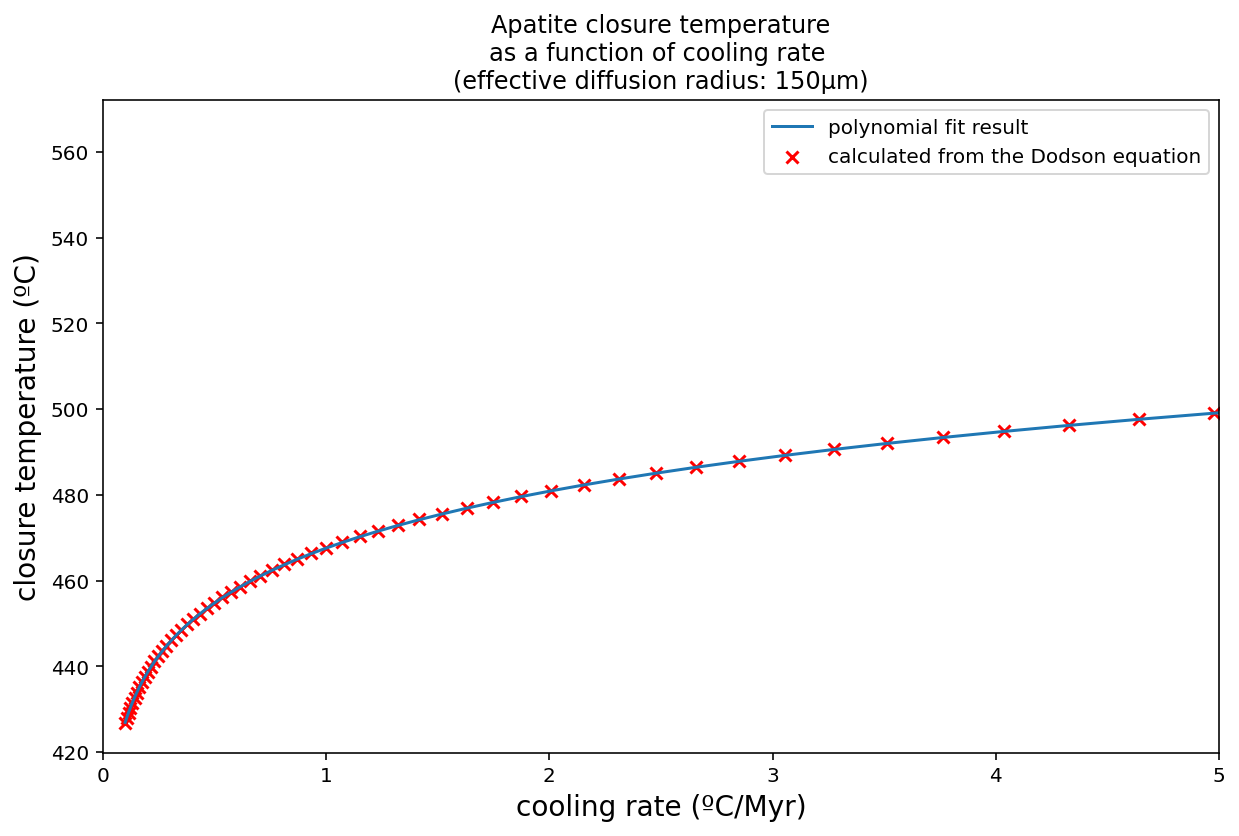

In [13]:
apatite_E = 231*1000

apatite_D0 = 1.27e-8
cooling_rate = np.logspace(-1, 2 ,100)/Julian_year/1e6

apatite_a = 150/1e6

closure_T_list = []
for i in cooling_rate:
    closure_T_list.append(closure_temps(600, apatite_E, apatite_D0, R, A, apatite_a, i))

a, b, c = np.ndarray.flatten(np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1))
print('a: ', a, 'b: ', b, 'c: ', c)

fit_series = pd.Series(['Apatite', a, b, c], index = columns)
log_closure_temp_fit_df=log_closure_temp_fit_df.append(fit_series, ignore_index=1)

x = cooling_rate*Julian_year*1e6
y = a*np.log(x)**2+b*np.log(x)+c


plt.figure(figsize=(10, 6))
plt.scatter(cooling_rate*Julian_year*1e6, closure_T_list, marker ='x', color = 'r', label='calculated from the Dodson equation')
plt.plot(x, y, label='polynomial fit result')
plt.xlim(0, 5)
plt.xlabel('cooling rate (ºC/Myr)', fontsize=14)
plt.ylabel('closure temperature (ºC)', fontsize=14)
plt.title('Apatite closure temperature\nas a function of cooling rate \n(effective diffusion radius: 150µm)')
plt.legend()
plt.show()

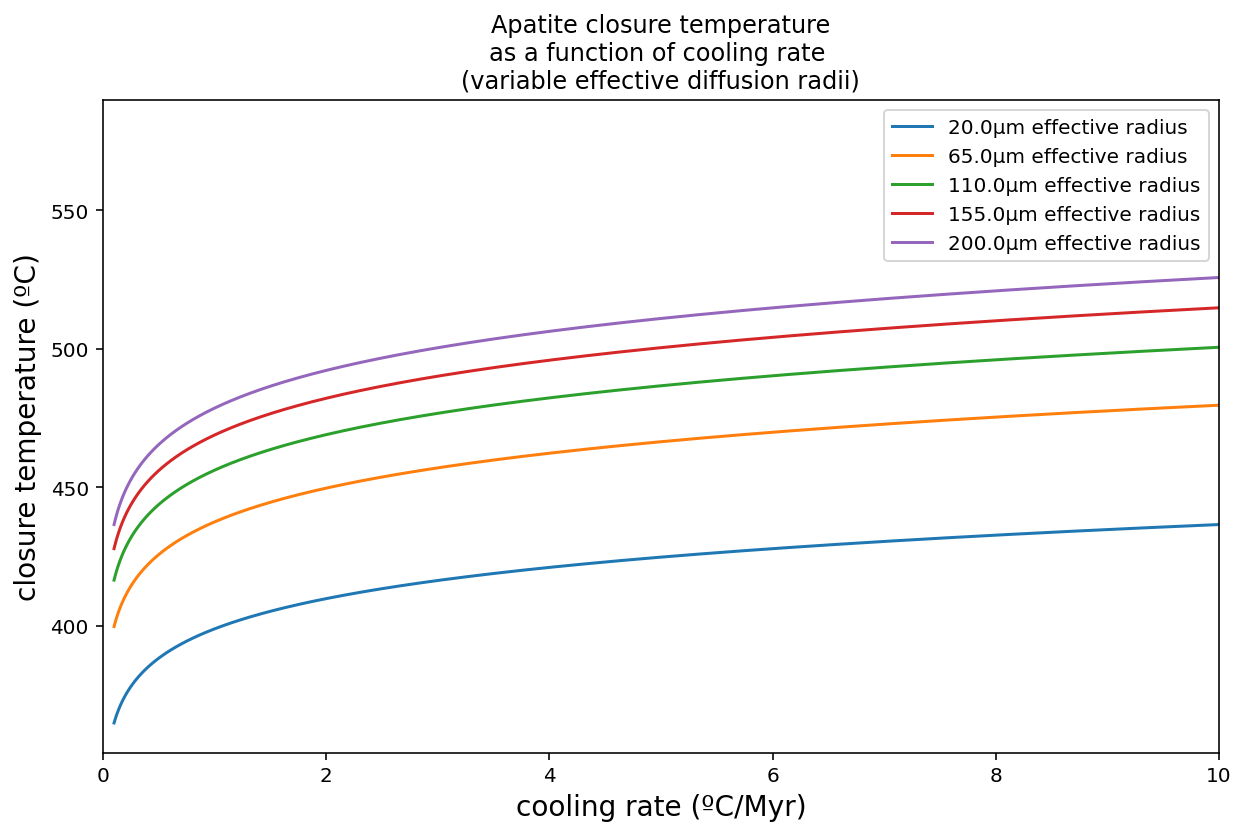

In [14]:
apatite_a = np.linspace(20, 200, 5)/1e6

plt.figure(figsize=(10, 6))

for a in apatite_a:
    closure_T_list = []
    for i in cooling_rate:
        closure_T_list.append(closure_temps(550, apatite_E, apatite_D0, R, A, a, i))

# a, b, c = np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2)  
# a, b, c = np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1)
# x = cooling_rate*Julian_year*1e6
# y = a*np.log(x)**2+b*np.log(x)+c
# print('a: ', a, 'b: ', b, 'c: ', c)

    plt.plot(cooling_rate*Julian_year*1e6, closure_T_list, label=str(a*1e6)+'µm effective radius')
# plt.plot(x, y, label='polynomial fit result')
plt.xlim(0,10)
plt.xlabel('cooling rate (ºC/Myr)', fontsize=14)
plt.ylabel('closure temperature (ºC)', fontsize=14)
plt.title('Apatite closure temperature\nas a function of cooling rate \n(variable effective diffusion radii)')
plt.legend()
plt.show()

### Rutile Pb closure temperature calculation and fit

a:  0.7 b:  24.2 c:  603.9


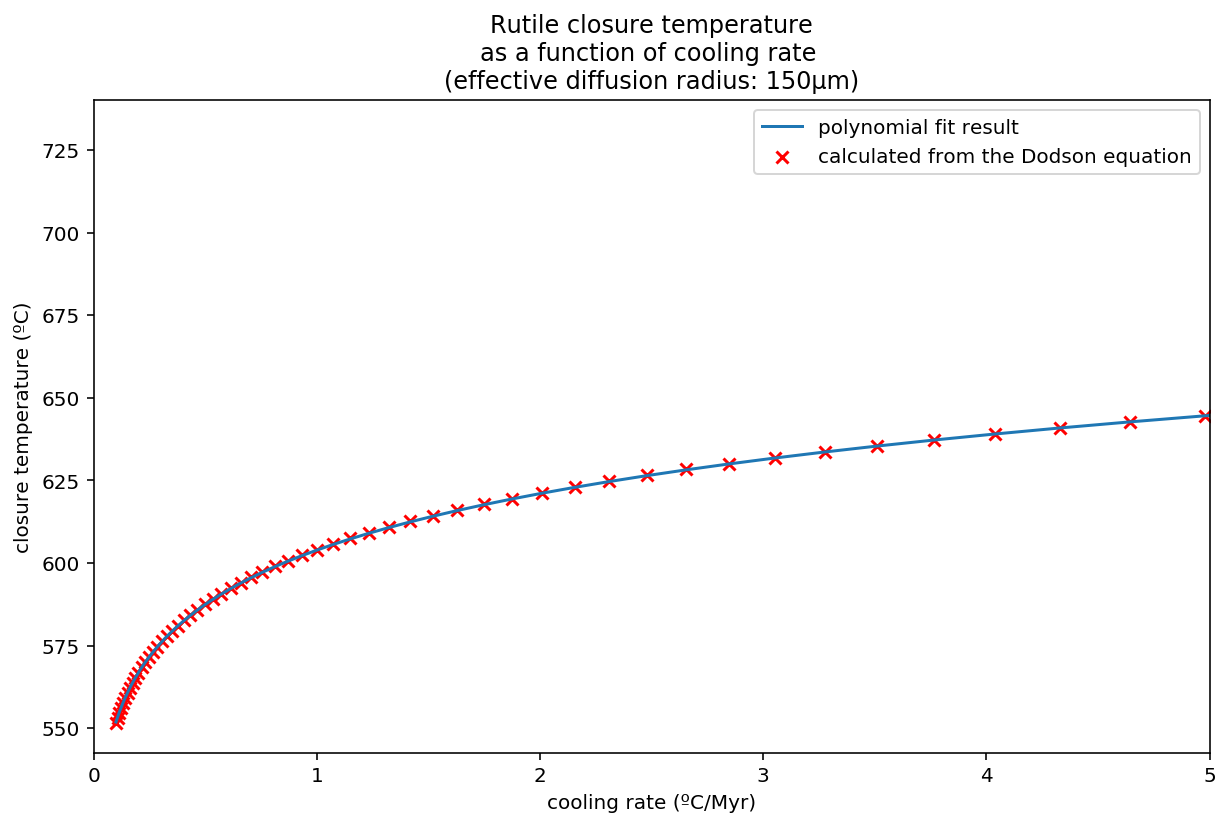

In [10]:
rutile_E = 250*1000

rutile_D0 = 3.9E-10
cooling_rate = np.logspace(-1, 2 ,100)/Julian_year/1e6

rutile_a = 150/1e6

closure_T_list = []
for i in cooling_rate:
    closure_T_list.append(closure_temps(600, rutile_E, rutile_D0, R, A, rutile_a, i))

a, b, c = np.ndarray.flatten(np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1))
print('a: ', a, 'b: ', b, 'c: ', c)

fit_series = pd.Series(['Rutile', a, b, c], index = columns)
log_closure_temp_fit_df=log_closure_temp_fit_df.append(fit_series, ignore_index=1)

x = cooling_rate*Julian_year*1e6
y = a*np.log(x)**2+b*np.log(x)+c


plt.figure(figsize=(10, 6))
plt.scatter(cooling_rate*Julian_year*1e6, closure_T_list, marker ='x', color = 'r', label='calculated from the Dodson equation')
plt.plot(x, y, label='polynomial fit result')
plt.xlim(0, 5)
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Rutile closure temperature\nas a function of cooling rate \n(effective diffusion radius: 150µm)')
plt.legend()
plt.show()

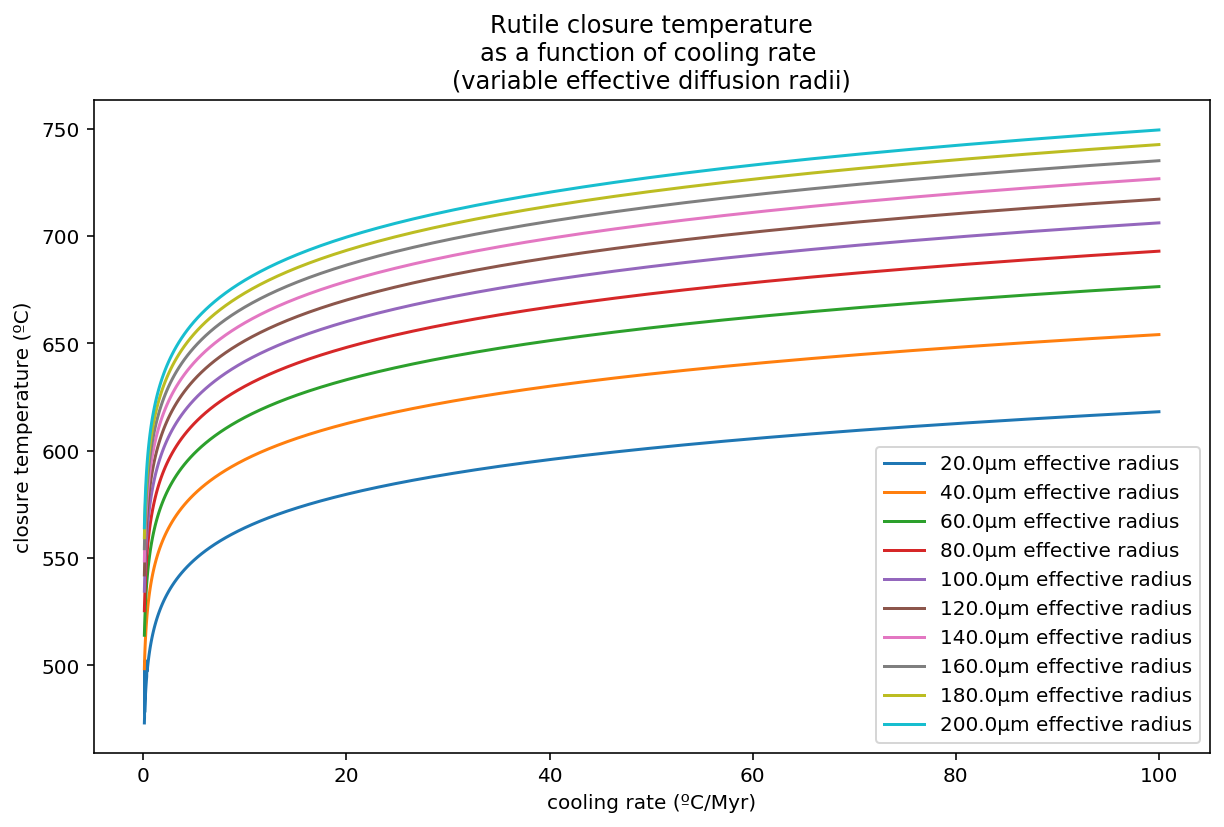

In [21]:
rutile_a = np.linspace(20, 200, 10)/1e6

plt.figure(figsize=(10, 6))

for a in rutile_a:
    closure_T_list = []
    for i in cooling_rate:
        closure_T_list.append(closure_temps(550, rutile_E, rutile_D0, R, A, a, i))

# a, b, c = np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2)  
# a, b, c = np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1)
# x = cooling_rate*Julian_year*1e6
# y = a*np.log(x)**2+b*np.log(x)+c
# print('a: ', a, 'b: ', b, 'c: ', c)

    plt.plot(cooling_rate*Julian_year*1e6, closure_T_list, label=str(a*1e6)+'µm effective radius')
# plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Rutile closure temperature\nas a function of cooling rate \n(variable effective diffusion radii)')
plt.legend()
plt.show()

### Titanite Pb closure temperature calculation and fit

a:  0.4 b:  17.6 c:  577.7


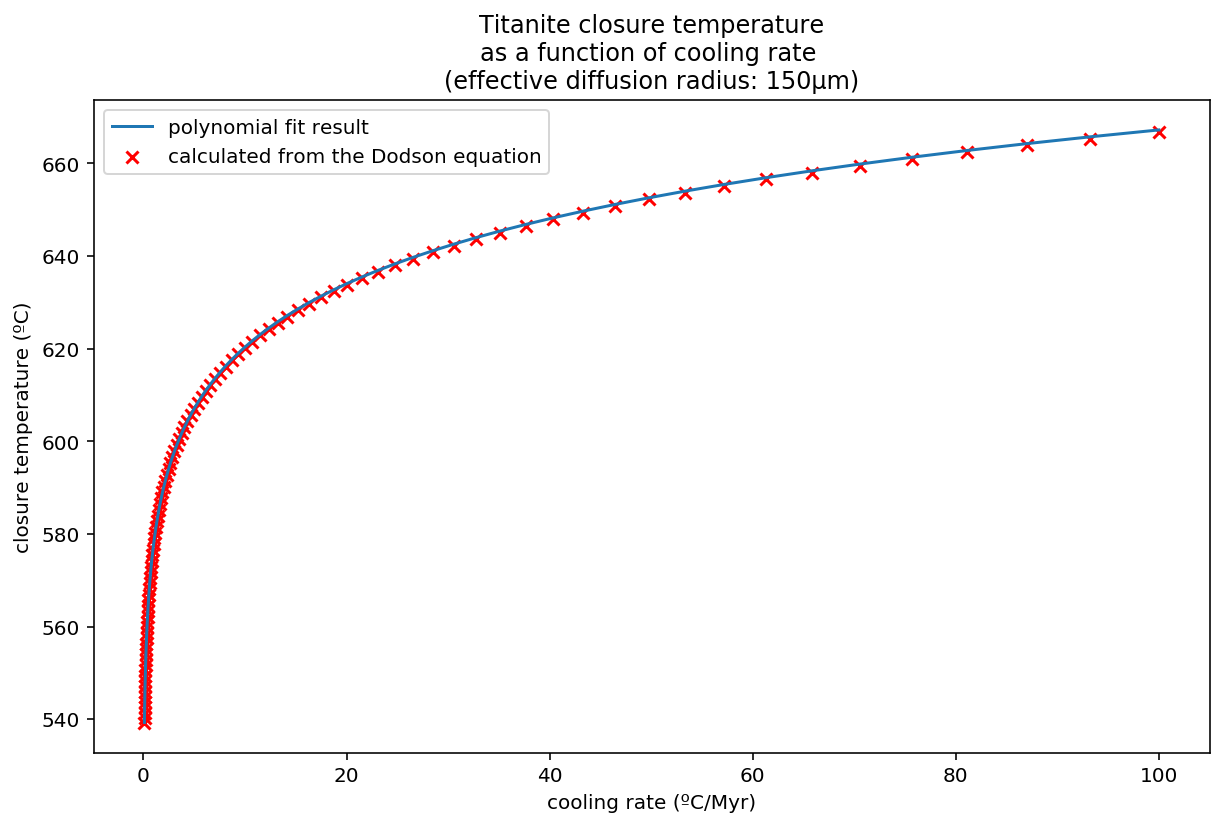

In [46]:
titanite_E = 329*1000

titanite_D0 = 0.000111
cooling_rate = np.logspace(-1, 2 ,100)/Julian_year/1e6

titanite_a = 150/1e6

closure_T_list = []
for i in cooling_rate:
    closure_T_list.append(closure_temps(600, titanite_E, titanite_D0, R, A, titanite_a, i))

a, b, c = np.ndarray.flatten(np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1))
print('a: ', a, 'b: ', b, 'c: ', c)

fit_series = pd.Series(['Titanite', a, b, c], index = columns)
log_closure_temp_fit_df=log_closure_temp_fit_df.append(fit_series, ignore_index=1)

x = cooling_rate*Julian_year*1e6
y = a*np.log(x)**2+b*np.log(x)+c

plt.figure(figsize=(10, 6))
plt.scatter(cooling_rate*Julian_year*1e6, closure_T_list, marker ='x', color = 'r', label='calculated from the Dodson equation')
plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Titanite closure temperature\nas a function of cooling rate \n(effective diffusion radius: 150µm)')
plt.legend()
plt.show()

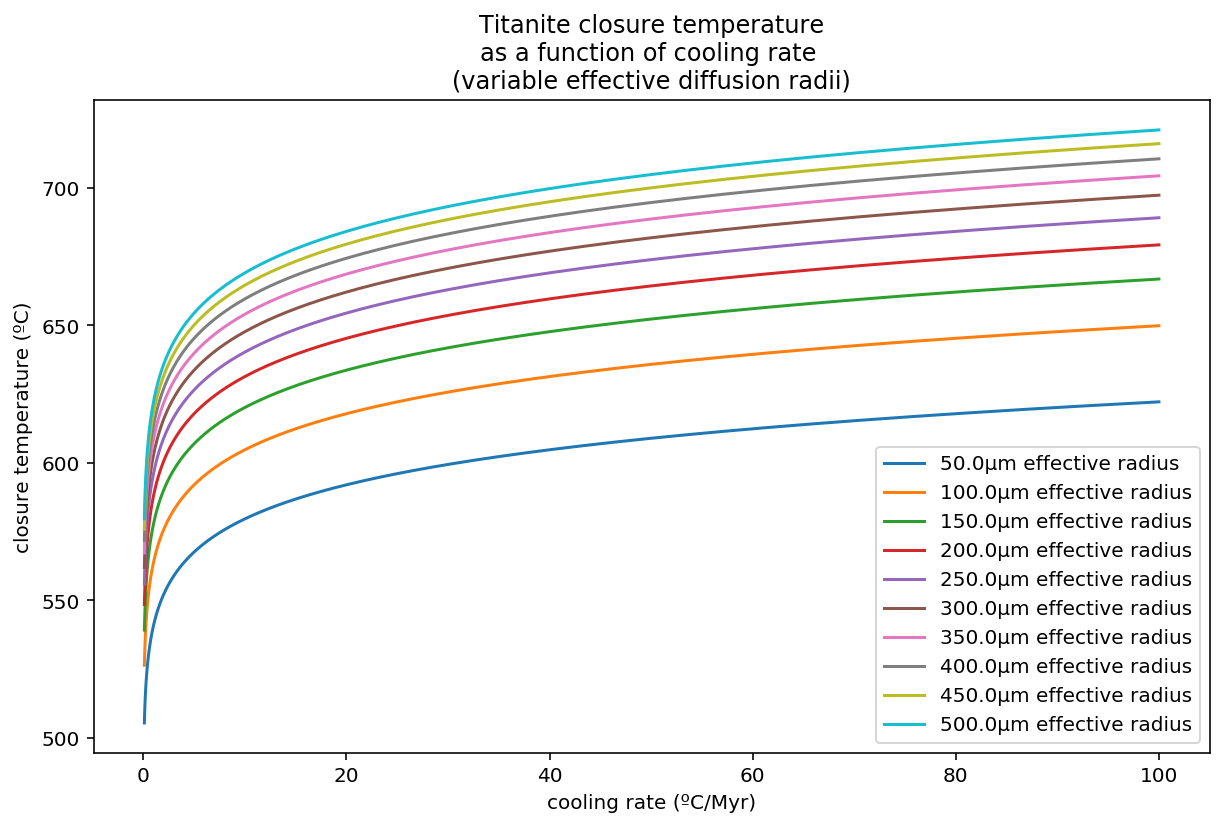

In [47]:
titanite_a = np.linspace(50, 500, 10)/1e6

plt.figure(figsize=(10, 6))

for a in titanite_a:
    closure_T_list = []
    for i in cooling_rate:
        closure_T_list.append(closure_temps(600, titanite_E, titanite_D0, R, A, a, i))

# a, b, c = np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2)  
# a, b, c = np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1)
# x = cooling_rate*Julian_year*1e6
# y = a*np.log(x)**2+b*np.log(x)+c
# print('a: ', a, 'b: ', b, 'c: ', c)

    plt.plot(cooling_rate*Julian_year*1e6, closure_T_list, label=str(a*1e6)+'µm effective radius')
# plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Titanite closure temperature\nas a function of cooling rate \n(variable effective diffusion radii)')
plt.legend()
plt.show()

### Monazite Pb closure temperature calculation and fit

a:  0.4 b:  22.1 c:  1003.6


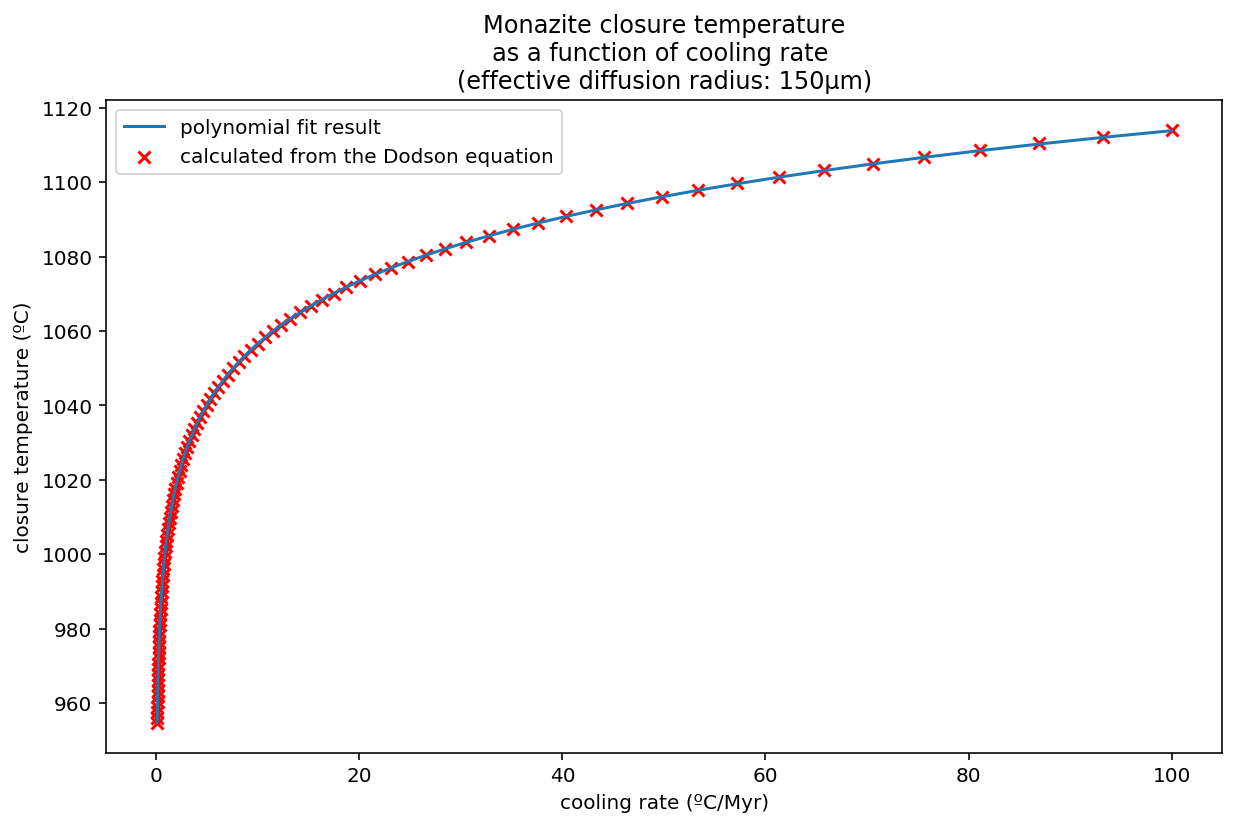

In [17]:
monazite_E = 592*1000

monazite_D0 = 9.38E-01
cooling_rate = np.logspace(-1, 2 ,100)/Julian_year/1e6

monazite_a = 150/1e6

closure_T_list = []
for i in cooling_rate:
    closure_T_list.append(closure_temps(1000, monazite_E, monazite_D0, R, A, monazite_a, i))

a, b, c = np.ndarray.flatten(np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1))
print('a: ', a, 'b: ', b, 'c: ', c)

fit_series = pd.Series(['Monazite', a, b, c], index = columns)
log_closure_temp_fit_df=log_closure_temp_fit_df.append(fit_series, ignore_index=1)

x = cooling_rate*Julian_year*1e6
y = a*np.log(x)**2+b*np.log(x)+c

plt.figure(figsize=(10, 6))
plt.scatter(cooling_rate*Julian_year*1e6, closure_T_list, marker ='x', color = 'r', label='calculated from the Dodson equation')
plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Monazite closure temperature\nas a function of cooling rate \n(effective diffusion radius: 150µm)')
plt.legend()
plt.show()

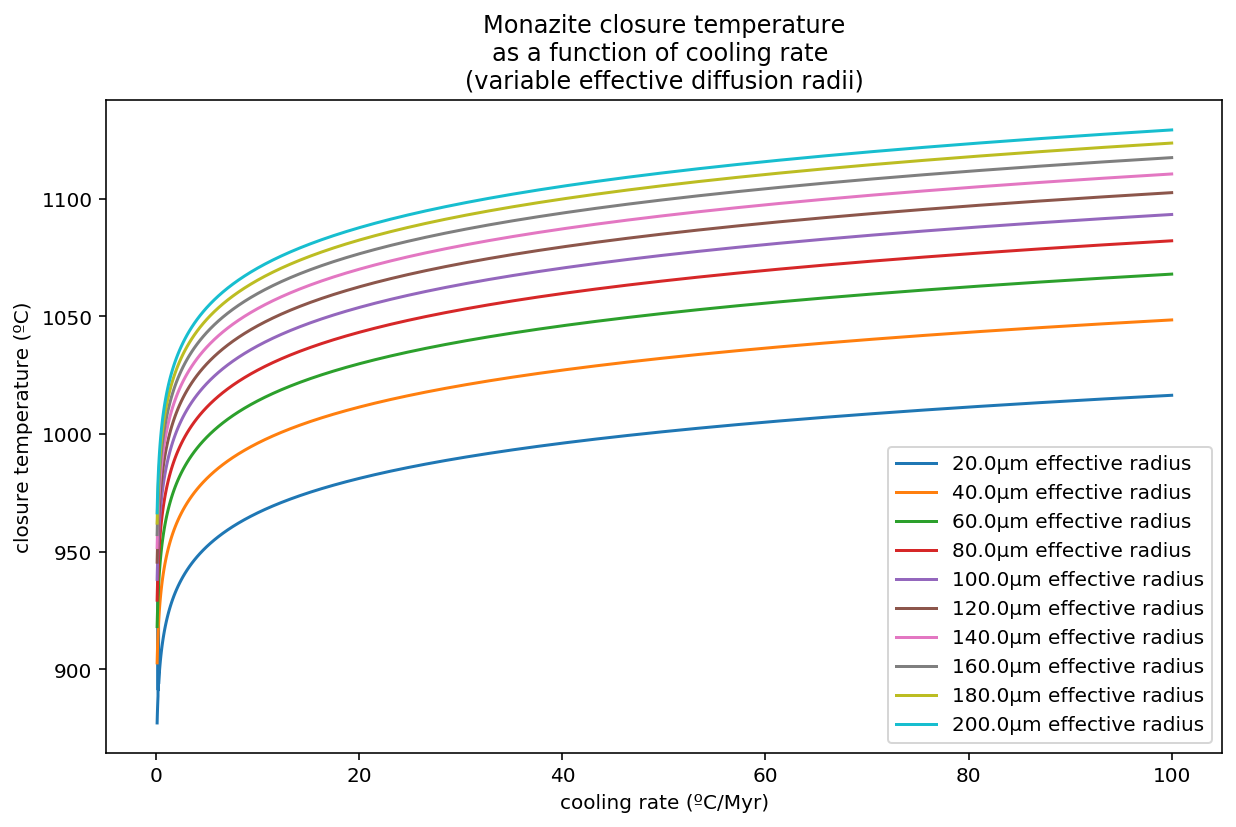

In [18]:
monazite_a = np.linspace(20, 200, 10)/1e6

plt.figure(figsize=(10, 6))

for a in titanite_a:
    closure_T_list = []
    for i in cooling_rate:
        closure_T_list.append(closure_temps(1000, monazite_E, monazite_D0, R, A, a, i))

# a, b, c = np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2)  
# a, b, c = np.round(np.polyfit(np.log(cooling_rate*Julian_year*1e6), closure_T_list, 2),1)
# x = cooling_rate*Julian_year*1e6
# y = a*np.log(x)**2+b*np.log(x)+c
# print('a: ', a, 'b: ', b, 'c: ', c)

    plt.plot(cooling_rate*Julian_year*1e6, closure_T_list, label=str(a*1e6)+'µm effective radius')
# plt.plot(x, y, label='polynomial fit result')
plt.xlabel('cooling rate (ºC/Myr)')
plt.ylabel('closure temperature (ºC)')
plt.title('Monazite closure temperature\nas a function of cooling rate \n(variable effective diffusion radii)')
plt.legend()
plt.show()

In [22]:
log_closure_temp_fit_df

,mineral,a,b,c
0,Biotite,0.3,12.0,272.1
1,Hornblende,0.4,17.0,482.8
2,Rutile,0.7,24.1,603.9
3,Titanite,0.4,17.6,577.7
4,Monazite,0.4,22.1,1003.6


In [23]:
log_closure_temp_fit_df.to_csv('code_output/closure_temp_fits_150.csv')

## Evaluting the Pb of diffusive loss in zircon

Shown below are conditions for diffusional Pb loss in crystalline zircon for zircons of effective radii of 100 µm. Curves represent time–temperature conditions under which zircon will lose the indicated fraction of total Pb.


- Cherniak, D. J., & Watson, E. B. (2001). Pb diffusion in zircon. Chemical Geology, 172(1-2), 5-24.

In [6]:
R = 8.314462618
T = 1000+273

def get_temp_from_yr(diff_length, yrs):
    return -545000/np.log((diff_length/1000000)**2/0.0776/Julian_year/yrs)/R - 273.15


In [ ]:
# to get % loss we need:
def temp_yr_given_perc(percent_loss = 0.9, eff_radii=100, yrs = np.logspace(0, 9, 50)):
    eff_radii = eff_radii
    perc_loss = percent_loss
    zircon_vol = 4/3*np.pi*eff_radii**3
    left_vol = zircon_vol*(1-perc_loss)*3/4/np.pi
    left_radii = np.cbrt(left_vol)

    diff_length = eff_radii-left_radii

    yrs = yrs

    temps = get_temp_from_yr(diff_length, yrs)
    return temps

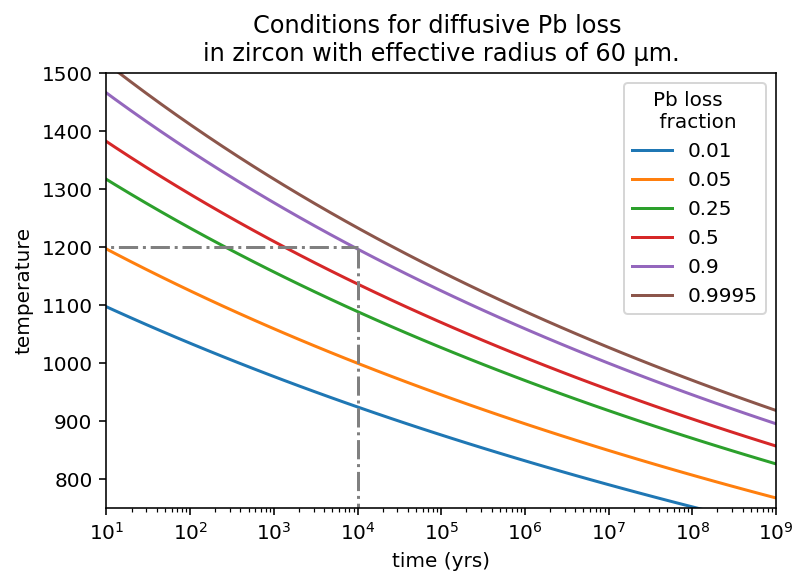

In [9]:
perc = [0.01, 0.05, 0.25, 0.5, 0.9, 0.9995]
yrs = np.logspace(0, 9, 50)
temps = []
for i in perc:
    temps.append(temp_yr_given_perc(percent_loss = i, eff_radii=60, yrs = np.logspace(0, 9, 50)))
for i in range(len(temps)):
    plt.plot(yrs, temps[i], label=str(perc[i]))
    
plt.plot([1,1e4], [1200, 1200], '-.',color = 'grey', )
plt.plot([1e4,1e4], [0, 1200], '-.',color = 'grey', )
plt.xlim(10, 1e9)
plt.ylim(750, 1500)
plt.xticks([1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9])
plt.xscale('log')
plt.legend(title="Pb loss \n fraction")
plt.title('Conditions for diffusive Pb loss \nin zircon with effective radius of 60 µm.')
plt.xlabel('time (yrs)')
plt.ylabel('temperature')
# plt.savefig('code_output/geochron/Pb_loss_condition_60.pdf')
plt.show()

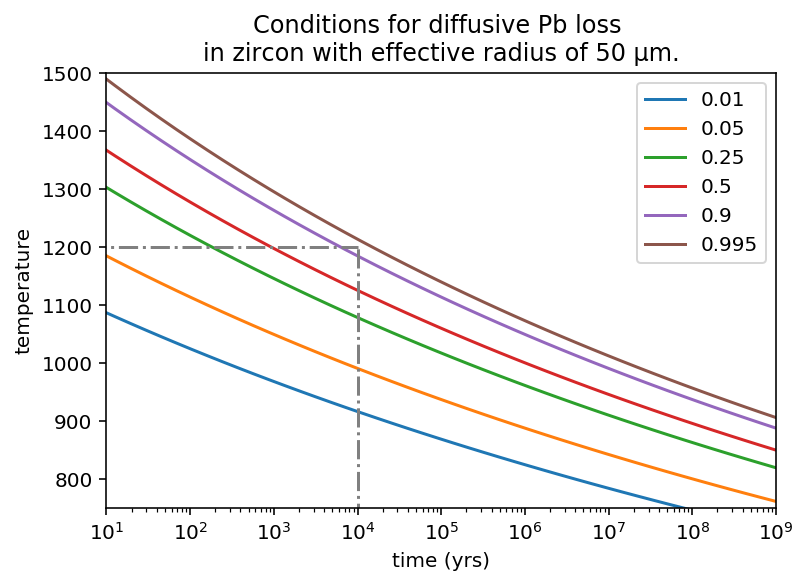

In [10]:
perc = [0.01, 0.05, 0.25, 0.5, 0.9, 0.995]
yrs = np.logspace(0, 9, 50)
temps = []
for i in perc:
    temps.append(temp_yr_given_perc(percent_loss = i, eff_radii=50, yrs = np.logspace(0, 9, 50)))
for i in range(len(temps)):
    plt.plot(yrs, temps[i], label=str(perc[i]))
    
plt.plot([1,1e4], [1200, 1200], '-.',color = 'grey', )
plt.plot([1e4,1e4], [0, 1200], '-.',color = 'grey', )
plt.xlim(10, 1e9)
plt.ylim(750, 1500)
plt.xticks([1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9])
plt.xscale('log')
plt.legend()
plt.title('Conditions for diffusive Pb loss \nin zircon with effective radius of 50 µm.')
plt.xlabel('time (yrs)')
plt.ylabel('temperature')
plt.show()

### Evaluating the possible Dy zoning thickness being preserved given >90% Pb loss condition

In [11]:
def get_temp_from_Dy_zoning(zone_thickness, yrs, k=3.3e-2):
    zone_thickness = zone_thickness/1000000/2
    return -743000/np.log(k*zone_thickness**2/Julian_year/yrs/2.29e5)/R - 273.15

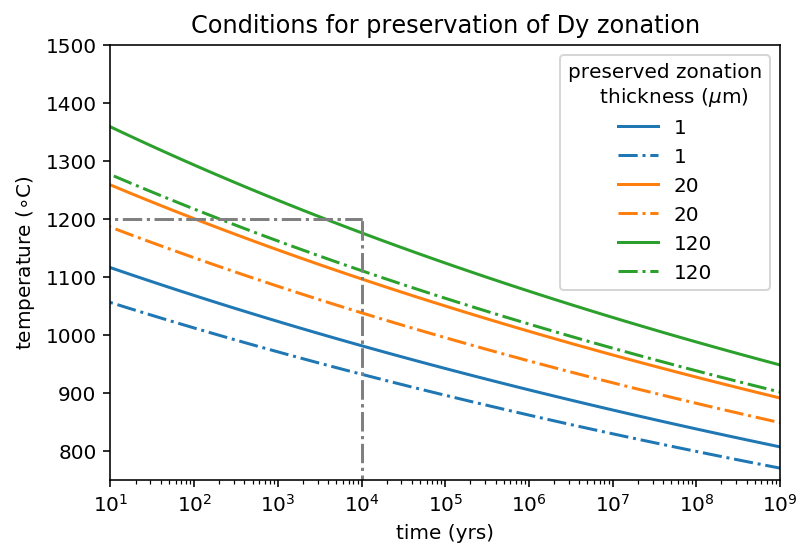

In [12]:
zone_thicknesses = [1, 20, 120]
yrs = np.logspace(0, 10, 50)
disappear_temps = []
fuzzing_temps = []

for i in zone_thicknesses:
    disappear_temps.append(get_temp_from_Dy_zoning(i, yrs, k=3.3e-2))
    fuzzing_temps.append(get_temp_from_Dy_zoning(i, yrs, k=1.8e-3))
for i in range(len(disappear_temps)):
    plt.plot(yrs, disappear_temps[i], label=str(zone_thicknesses[i]), color = 'C'+str(i))
    plt.plot(yrs, fuzzing_temps[i], '-.', label=str(zone_thicknesses[i]), color = 'C'+str(i))
   
    
plt.plot([1,1e4], [1200, 1200], '-.',color = 'grey', )
plt.plot([1e4,1e4], [0, 1200], '-.',color = 'grey', )

plt.plot([1,1e4], [1200, 1200], '-.',color = 'grey', )
plt.plot([1e4,1e4], [0, 1200], '-.',color = 'grey', )
plt.xlim(10, 1e9)
plt.ylim(750, 1500)
plt.xticks([1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9])
plt.xscale('log')
plt.legend(title='preserved zonation\n     thickness ($\mu$m)')
# leg.get_title().set_ha("right")
plt.title('Conditions for preservation of Dy zonation')
plt.xlabel('time (yrs)')
plt.ylabel('temperature ($\circ$C)')
# plt.savefig('code_output/geochron/Dy_zoning.pdf')
plt.show()